# Atoti DirectQuery with Snowflake: Vectorizing data from Cloud Data Warehouse
\[_In case you’re unable to see the Atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/atoti/blob/main/02-technical-guides/directquery-vector/main.ipynb)._]


When working with big data, how we store data is important.   
Not only does it determine the amount of storage space it takes, it also affects how we implement our aggregations and how much computation power the implementation requires.  

This notebook demonstrates how we can make use of vectors to perform effective aggregation.  
Most importantly, this notebook shows how easily we can convert repetitive data columns/rows into Vectors by using [Atoti's DirectQuery](https://docs.atoti.io/latest/how_tos/use_directquery.html) to connect to [cloud data warehouse](https://www.snowflake.com/data-cloud-glossary/data-warehousing/). The example in this notebook applies regardless whether the database is hosted on cloud or on-premise (e.g. for [ClickHouse](https://clickhouse.com/clickhouse) and [Microsoft SQL Server](https://www.microsoft.com/en-sg/sql-server/sql-server-downloads)).

An example of repetitive data columns/rows are values collected over a time-series, e.g. [Profit and Loss (PnL)](https://en.wikipedia.org/wiki/PnL_explained) over time. 
So, why do we need vectors for such cases? 

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=directQuery-vector" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Atoti table" /></a></div>

## Why Vectors?

We will see with a [Value at Risk (VaR) calculation example using historical method](https://www.investopedia.com/articles/04/092904.asp#toc-1-historical-method).  For each trade on a given day, we have 250 days worth of historical PnL.  

### Column-based historical data storage  

In the below structure, data is compact as all the historical PnL is mapped to one row of key data each.  
However, it becomes cumbersome to iterate and perform aggregation across 250 columns of data.  

In [1]:
import pandas as pd

df = pd.read_csv(
    "https://data.atoti.io/notebooks/direct-query/data/TradePnLs_0_25000.csv"
)
df.head(2)

,BookId,AsOfDate,TradeId,DataSet,RiskFactor,RiskClass,SensitivityName,ccy,pnl_vector1,pnl_vector2,...,pnl_vector241,pnl_vector242,pnl_vector243,pnl_vector244,pnl_vector245,pnl_vector246,pnl_vector247,pnl_vector248,pnl_vector249,pnl_vector250
0,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,NaN,NaN,NaN,EUR,223.0,1137.0,...,873.0,-6.0,886.0,-12.0,1310.0,-241.0,343.0,-338.0,-512.0,619.0
1,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Credit spread_Allegheny Energy_Implied spread,Credit spread,delta,EUR,-426.0,-57.0,...,2192.0,-130.0,-73.0,1079.0,1731.0,-778.0,-75.0,2789.0,1202.0,1715.0


### Row-based historical data storage  

In the below data transformation, we can easily work with the PnL value through the column `pnl_vector`.  
However, now we have duplicated data for the columns `BookId`, `AsOfDate`, `TradeId`, `DataSet`, `RiskFactor`, `RiskClass`, `SensitivityName` and `ccy`.  

In [2]:
pd.melt(
    df,
    id_vars=[col for col in df.columns.to_list() if not col.startswith("pnl_vector")],
    value_vars=[col for col in df.columns.to_list() if col.startswith("pnl_vector")],
    value_name="pnl_vector",
    var_name="pnl_vector_order",
)

,BookId,AsOfDate,TradeId,DataSet,RiskFactor,RiskClass,SensitivityName,ccy,pnl_vector_order,pnl_vector
0,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,NaN,NaN,NaN,EUR,pnl_vector1,223.0
1,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Credit spread_Allegheny Energy_Implied spread,Credit spread,delta,EUR,pnl_vector1,-426.0
2,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Foreign exchange_USD_Spot price,Foreign exchange,delta,EUR,pnl_vector1,-38525.0
3,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Interest rate_USD.OIS_Implied yield,Interest rate,delta,EUR,pnl_vector1,65.0
4,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Stressed,NaN,NaN,NaN,EUR,pnl_vector1,246.0
...,...,...,...,...,...,...,...,...,...,...
6249995,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Historical,Foreign exchange_USD_Spot price,Foreign exchange,delta,EUR,pnl_vector250,8533.0
6249996,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Historical,Interest rate_USD.OIS_Implied yield,Interest rate,delta,EUR,pnl_vector250,149.0
6249997,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Stressed,NaN,NaN,NaN,EUR,pnl_vector250,-261.0
6249998,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Stressed,Equity_SpaceX_Repo rate,Equity,delta,EUR,pnl_vector250,-188.0


### Historical data stored as Vector

In [3]:
vector_cols = [col for col in df.columns.to_list() if col.startswith("pnl_vector")]
df["pnl_vector"] = df[vector_cols].values.tolist()
df.drop(columns=vector_cols, inplace=True)
df.head(2)

,BookId,AsOfDate,TradeId,DataSet,RiskFactor,RiskClass,SensitivityName,ccy,pnl_vector
0,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,NaN,NaN,NaN,EUR,"[223.0, 1137.0, 272.0, 500.0, 158.0, 398.0, -1..."
1,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Credit spread_Allegheny Energy_Implied spread,Credit spread,delta,EUR,"[-426.0, -57.0, -1600.0, -1020.0, 2548.0, 1593..."


### Aggregation on Vector

Now, by converting the PnL columns into a list of values, or what we call a Vector, we can apply aggregation operations across the vector more easily without duplicating key data.

In [4]:
import numpy as np


def calculate_percentile(lst):
    return np.percentile(lst, 5)


df["95% VaR"] = df["pnl_vector"].apply(calculate_percentile)
df.head()

,BookId,AsOfDate,TradeId,DataSet,RiskFactor,RiskClass,SensitivityName,ccy,pnl_vector,95% VaR
0,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,NaN,NaN,NaN,EUR,"[223.0, 1137.0, 272.0, 500.0, 158.0, 398.0, -1...",-821.65
1,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Credit spread_Allegheny Energy_Implied spread,Credit spread,delta,EUR,"[-426.0, -57.0, -1600.0, -1020.0, 2548.0, 1593...",-1354.80
2,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Foreign exchange_USD_Spot price,Foreign exchange,delta,EUR,"[-38525.0, 39667.0, -20251.0, -27725.0, 38539....",-50180.20
3,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Interest rate_USD.OIS_Implied yield,Interest rate,delta,EUR,"[65.0, 107.0, 94.0, 28.0, 8.0, -15.0, 270.0, 1...",-200.55
4,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Stressed,NaN,NaN,NaN,EUR,"[246.0, 753.0, 387.0, 259.0, 112.0, 413.0, 77....",-803.15


## Database Support for Vectors

Not all databases offer native [support for vectors](https://docs.activeviam.com/products/atoti/server/latest/docs/directquery/directquery-vectors/). Some databases such as [ClickHouse](https://clickhouse.com/docs/en/sql-reference/data-types/array) offer native support for vectors as an Array type. Databases like Google BigQuery and Snowflakes supports list queries but not aggregation queries.

<img src="https://data.atoti.io/notebooks/direct-query/img/vector_support.png" />

Using [Atoti's aggregation function for Vectors](https://docs.atoti.io/latest/lib/atoti/atoti.array.html), we can now segregate the vector computation from the database.
Where vectors are not supported natively or are partially supported, Atoti's DirectQuery fills the technical gap by emulating vectors for database.  

## Atoti DirectQuery

Atoti supports the following list of external databases such as [Google BigQuery](https://cloud.google.com/bigquery), [ClickHouse](https://clickhouse.com/) and [Databricks](https://www.databricks.com/). Check out the documentation for the [list of databases supported](https://docs.atoti.io/latest/reference.html#directquery).  
In this example, we demonstrate how we connect to Snowflake to perform VaR computation using Vector.  

### Data
If you would like to give it a try, uncomment the below cell to download part of the data used for this notebook and load it into a database of your choice.  

In [4]:
# import zipfile

# import wget
# from IPython.display import clear_output, display


# def bar_custom(current, total, width=80):
#     clear_output(wait=True)
#     print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))


# url = "https://data.atoti.io/notebooks/direct-query/data/data.zip"
# filename = wget.download(url, bar=bar_custom)

# with zipfile.ZipFile("data.zip", "r") as zip_ref:
#     zip_ref.extractall()

### Instantiate Atoti - Memory configuration

In [6]:
import os

import atoti as tt

<img src="https://data.atoti.io/notebooks/direct-query/img/snowflake_data_volume.png" />

In our server instance, we have 1.7TB worth of Trade data on Snowflake.  
We have to prepare our machine to handle the load by [configuring the memory size](https://docs.atoti.io/latest/deployment/deployment_setup.html#memory) using `java_option` during the instantiation of the session.  
However, we only allocate a fraction of memory to the instance, in comparison to the amount of data we have in the Snowflake instance.

In [7]:
session = tt.Session(
    java_options=["-Xmx10g"],
)

### Connecting to Snowflake

#### Prerequisite  

##### Atoti plugins 
We have to install the [DirectQuery plugins](https://docs.atoti.io/latest/reference.html#directquery) and a valid license to [unlock all the Atoti features](https://docs.atoti.io/latest/how_tos/unlock_all_features.html).  
Uncomment the following to install the plugin for the DirectQuery plugin for Snowflake.

In [8]:
# ! pip install atoti_directquery_snowflake

##### Snowflake permission

In Snowflake, we do the followings:

__Step 1 - create a role to grant users the permission to run queries.__

Either use the Snowflake GUI to create the role interactively or run the following script to create the role:  

```
CREATE ROLE IF NOT EXISTS QUERIER COMMENT="Role to run queries"
```

<img src="https://data.atoti.io/notebooks/direct-query/img/snowflake_role.png" width="800px"/>  

__Step 2 - grant privileges to role__

Execute the following to [grant the role the minimum privilege](https://docs.activeviam.com/products/atoti/server/latest/docs/directquery/connect_to_external/connect_to_snowflake/#grant-required-privileges-to-this-role) to query the database.
                                                         
```
GRANT USAGE ON WAREHOUSE COMPUTE_WH TO ROLE QUERIER;

GRANT USAGE ON DATABASE ATOTI TO ROLE QUERIER;

GRANT USAGE ON SCHEMA VAR TO ROLE QUERIER;

GRANT SELECT ON ALL TABLES IN SCHEMA ATOTI.VAR to ROLE QUERIER;
```

<img src="https://data.atoti.io/notebooks/direct-query/img/snowflake_privileges.png" />

__Step 3 - grant role to user__

Grant the above role to user:  

<img src="https://data.atoti.io/notebooks/direct-query/img/snowflake_grant_role.png" width="800px"/>


Reference documentation:
- Atoti documentation on [connecting to Snowflake](https://docs.activeviam.com/products/atoti/server/latest/docs/directquery/connect_to_external/connect_to_snowflake/).
- Snowflake documentation on [granting privilege](https://docs.snowflake.com/en/sql-reference/sql/grant-privilege#examples).  

You may use the [script](snowflake_privilege.sql) in the use case folder to create and grant user the corresponding permissions.  

#### Import Plugins for DirectQuery 

We will be using two components from the DirectQueryPlugin:
- [SnowflakeConnectionInfo](https://docs.atoti.io/latest/lib/atoti-directquery-snowflake/atoti_directquery_snowflake.connection_info.html): configure the connection information to Snowflake.
- [SnowflakeTableOptions](https://docs.atoti.io/latest/lib/atoti-directquery-snowflake/atoti_directquery_snowflake.table_options.html): configure the table options about the external table to create in Atoti  

⚠️Use the corresponding components for different databases if we are using a different one from Snowflake. E.g. we use [`ClickhouseConnectionInfo`](https://docs.atoti.io/latest/lib/atoti-directquery-clickhouse/atoti_directquery_clickhouse.connection_info.html) and [`ClickhouseTableOptions`](https://docs.atoti.io/latest/lib/atoti-directquery-clickhouse/atoti_directquery_clickhouse.table_options.html) if we are connecting to [ClickHouse](https://clickhouse.com/).

In [9]:
import os

from atoti_directquery_snowflake import SnowflakeConnectionInfo, SnowflakeTableOptions

#### JDBC Connection URL to Snowflake

We will connect to Snowflake using [JDBC URL](https://docs.snowflake.com/en/developer-guide/jdbc/jdbc-configure#jdbc-driver-connection-string).  

To uniquely identify an account in Snowflake, we must prepend our organization name to the account name:

`<orgname>-<account_name>`  

You can find these information from the bottom left corner of your Snowflake web account:  

<img src="https://data.atoti.io/notebooks/direct-query/img/snowflake_account.png" />  

Tips:  

1. Clicking on the `copy` will return you `<orgname>-<account_name>`. Replace the full-stop with a hypen to get the account_identifier for the JDBC URL e.g. SDLWLHU-XO19970 for our use case.
2. Instead of exposing your password in the codes, we can store it in an environment variable instead.

<img src="https://data.atoti.io/notebooks/direct-query/img/snowflake_env_variable.png" />

In [10]:
# os.environ["SNOWFLAKE_ACCOUNT_IDENTIFIER"] = SDLWLHU-XO19970
connection_info = SnowflakeConnectionInfo(
    f"jdbc:snowflake://{os.environ['SNOWFLAKE_ACCOUNT_IDENTIFIER']}.snowflakecomputing.com/?user=APP_USER&database=ATOTI&schema=VAR",
    password=os.environ["SNOWFLAKE_PASSWORD"],
)

db = session.connect_to_external_database(connection_info)

In [11]:
db.tables

ExternalTables(_tables={'DEMO_DB': {'INFORMATION_SCHEMA': [t[('DEMO_DB', 'INFORMATION_SCHEMA', 'APPLICABLE_ROLES')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'COLUMNS')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'DATABASES')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'ENABLED_ROLES')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'EVENT_TABLES')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'EXTERNAL_TABLES')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'FILE_FORMATS')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'FUNCTIONS')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'INFORMATION_SCHEMA_CATALOG_NAME')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'LOAD_HISTORY')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'OBJECT_PRIVILEGES')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'PACKAGES')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'PIPES')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'PROCEDURES')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'REFERENTIAL_CONSTRAINTS')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'REPLICATION_DATABASES')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'REPLICATION_GROUPS')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'SCHEMATA')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'SEQUENCES')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'STAGES')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'TABLES')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'TABLE_CONSTRAINTS')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'TABLE_PRIVILEGES')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'TABLE_STORAGE_METRICS')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'USAGE_PRIVILEGES')], t[('DEMO_DB', 'INFORMATION_SCHEMA', 'VIEWS')]]}, 'SNOWFLAKE_SAMPLE_DATA': {'TPCH_SF100': [t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF100', 'CUSTOMER')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF100', 'LINEITEM')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF100', 'NATION')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF100', 'ORDERS')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF100', 'PART')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF100', 'PARTSUPP')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF100', 'REGION')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF100', 'SUPPLIER')]], 'TPCDS_SF100TCL': [t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'CALL_CENTER')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'CATALOG_PAGE')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'CATALOG_RETURNS')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'CATALOG_SALES')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'CUSTOMER')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'CUSTOMER_ADDRESS')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'CUSTOMER_DEMOGRAPHICS')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'DATE_DIM')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'HOUSEHOLD_DEMOGRAPHICS')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'INCOME_BAND')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'INVENTORY')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'ITEM')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'PROMOTION')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'REASON')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'SHIP_MODE')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'STORE')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'STORE_RETURNS')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'STORE_SALES')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'TIME_DIM')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'WAREHOUSE')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'WEB_PAGE')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'WEB_RETURNS')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'WEB_SALES')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCDS_SF100TCL', 'WEB_SITE')]], 'TPCH_SF1000': [t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF1000', 'CUSTOMER')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF1000', 'LINEITEM')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF1000', 'NATION')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF1000', 'ORDERS')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF1000', 'PART')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF1000', 'PARTSUPP')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF1000', 'REGION')], t[('SNOWFLAKE_SAMPLE_DATA', 'TPCH_SF1000', 'SUPPLIER')]], 'TPCH_SF10': [t[('SNOWFLAKE_SAMPLE_DAT

Once we establish the connection, we can [add tables from the external database](add_external_table) to our atoti session.  
In our use case, we have the `TRADE_PNLS` table.  

In [12]:
db.tables["TRADE_PNLS"]

The table contains 250 PNL values for each `TRADEID` per `ASOFDATE`, i.e. 1 year historical PNL.  

<img src="https://data.atoti.io/notebooks/direct-query/img/snowflake_data.gif"  style="width:75%; margin:0 auto;"/> 
  
Using Atoti DirectQuery, we can now [convert these PNL_VECTOR columns into arrays](https://docs.atoti.io/latest/lib/atoti/atoti.directquery.multi_column_array_conversion.html#atoti.MultiColumnArrayConversion), optimizing the memory usage.  
In the event the PnL values are stored across rows instead of columns, we can convert them into arrays using [`atoti.MultiRowArrayConversion`](https://docs.atoti.io/latest/lib/atoti/atoti.directquery.multi_row_array_conversion.html) instead.  

In [13]:
trades_atoti = session.add_external_table(
    db.tables["TRADE_PNLS"],
    table_name="Trade PnL",
    options=SnowflakeTableOptions(
        keys=["ASOFDATE", "TRADEID", "BOOKID", "DATASET"],
        array_conversion=tt.MultiColumnArrayConversion(column_prefixes=["PNL_VECTOR"]),
    ),
)

In [14]:
session.link()

http://localhost:54244

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

Instead of managing 250 PNL columns that's named differently, the columns prefixed with `PNL_VECTOR` is now converted to a single column called `PNL_VECTOR`.  
The object is of now of the type `DOUBLE[]`.

In [15]:
trades_atoti.head()

RISKFACTOR  \
ASOFDATE   TRADEID                 BOOKID DATASET                                              
2021-04-16 IRS_BRL.IBOR6M 44eca43b 393    Stressed                                       N/A   
                                          Stressed           Foreign exchange_BRL_Spot price   
                                          Stressed    Interest rate_BRL.IBOR6M_Implied yield   
                                          Stressed       Interest rate_BRL.OIS_Implied yield   
           IRS_BRL.IBOR6M 4e2f5651 393    Historical                                     N/A   

                                                             RISKCLASS  \
ASOFDATE   TRADEID                 BOOKID DATASET                        
2021-04-16 IRS_BRL.IBOR6M 44eca43b 393    Stressed                  NA   
                                          Stressed    Foreign exchange   
                                          Stressed       Interest rate   
                                          Stressed       Interest rate   
           IRS_BRL.IBOR6M 4e2f5651 393    Historical                NA   

                                                     SENSITIVITYNAME  CCY  \
ASOFDATE   TRADEID                 BOOKID DATASET                           
2021-04-16 IRS_BRL.IBOR6M 44eca43b 393    Stressed               N/A  EUR   
                                          Stressed             delta  EUR   
                                          Stressed             delta  EUR   
                                          Stressed             delta  EUR   
           IRS_BRL.IBOR6M 4e2f5651 393    Historical             N/A  EUR   

                                                         TID  \
ASOFDATE   TRADEID                 BOOKID DATASET              
2021-04-16 IRS_BRL.IBOR6M 44eca43b 393    Stressed     58950   
                                          Stressed     58950   
                                          Stressed     58950   
                                          Stressed     58950   
           IRS_BRL.IBOR6M 4e2f5651 393    Historical  103576   

                                                                                             PNL_VECTOR  
ASOFDATE   TRADEID                 BOOKID DATASET                                                        
2021-04-16 IRS_BRL.IBOR6M 44eca43b 393    Stressed    [-179.0, 210.0, -28.0, 165.0, 728.0, -72.0, -1...  
                                          Stressed    [-67972.0, 157488.0, 85566.0, -39444.0, 80161....  
                                          Stressed    [-10307.0, 3373.0, 11590.0, 12744.0, -2764.0, ...  
                                          Stressed    [4001.0, -304.0, -2889.0, -1533.0, -3236.0, 41...  
           IRS_BRL.IBOR6M 4e2f5651 393    Historical  [127.0, -386.0, 1040.0, -16.0, -349.0, -462.0,...

In [16]:
len(trades_atoti)

2132330448

## Creating and enriching atoti cube

We can create more Atoti tables and join them to the base table.

In [17]:
books_atoti = session.add_external_table(
    db.tables["BOOKS"], options=SnowflakeTableOptions(keys=["BOOKID"])
)

trades_atoti.join(books_atoti)

We proceed to create a cube like what we always do with Atoti applications that uses other data sources.  
We can easily replace the data sources and retain the same code from this point onwards.

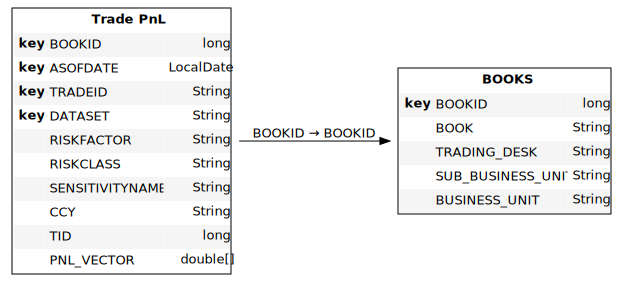

In [18]:
cube = session.create_cube(trades_atoti)
cube.schema

In [19]:
cube

### Hierarchy manipulation

In [20]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [21]:
h["ASOFDATE"].slicing = True
l["ASOFDATE"].order = tt.NaturalOrder(ascending=False)

In [22]:
h["TRADING BOOK HIERARCHY"] = [
    books_atoti["BUSINESS_UNIT"],
    books_atoti["SUB_BUSINESS_UNIT"],
    books_atoti["TRADING_DESK"],
    books_atoti["BOOK"],
]

del h["BUSINESS_UNIT"]
del h["SUB_BUSINESS_UNIT"]
del h["TRADING_DESK"]
del h["BOOK"]

Atoti is now able to retrieve data from Snowflake without storing them in-memory.  

In [23]:
session.visualize("PnL Vectors as of 2021-05-10")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

## Non-linear aggregation - Computing VaR 95 using Vector aggregation

Since we have the `PNL_VECTOR.SUM` which is the sum of the PNL value for each historical date, we can easily compute [value at risk (VaR)](https://www.investopedia.com/articles/04/092904.asp) at 95% confidence level using the vector as shown below:

In [24]:
m["VaR95"] = tt.array.quantile(m["PNL_VECTOR.SUM"], 1 - 0.95)

Depending on the query, VaR 95 is computed on the fly for each level in the query.

In [25]:
%%time
cube.query(m["VaR95"], levels=[l["BOOKID"]], filter=(l["ASOFDATE"] == "2021-05-10"))

CPU times: total: 0 ns
Wall time: 5.31 s


,VaR95
BOOKID,
1,"-20,052,712.50"
2,"-20,820,017.50"
3,"-34,228,080.90"
4,"-25,917,665.55"
5,"-32,018,914.65"
...,...
404,"-33,343,132.30"
405,"-34,867,464.45"
406,"-23,200,167.85"


## Speeding things up with Hybrid model

Queries depends on the performance of Snowflake. However, we can have a hybrid where we cache the data which we are actively using in memory.  
In this case, we will cache the data for all the levels other than `TRADEID` as of the latest `ASOFDATE` which is 2021-05-10.

In [26]:
from datetime import date

current_date = date(2021, 5, 10)

We exclude the `TRADEID` level in our aggregate provider as it is too granular and will increase the cardinality of our query.

In [27]:
[name for name, lvl in l.items() if "TRADEID" not in name]

[('Trade PnL', 'RISKCLASS', 'RISKCLASS'),
 ('Trade PnL', 'BOOKID', 'BOOKID'),
 ('BOOKS', 'TRADING BOOK HIERARCHY', 'BUSINESS_UNIT'),
 ('BOOKS', 'TRADING BOOK HIERARCHY', 'SUB_BUSINESS_UNIT'),
 ('BOOKS', 'TRADING BOOK HIERARCHY', 'TRADING_DESK'),
 ('BOOKS', 'TRADING BOOK HIERARCHY', 'BOOK'),
 ('Trade PnL', 'RISKFACTOR', 'RISKFACTOR'),
 ('Trade PnL', 'ASOFDATE', 'ASOFDATE'),
 ('Trade PnL', 'CCY', 'CCY'),
 ('Trade PnL', 'DATASET', 'DATASET'),
 ('Trade PnL', 'SENSITIVITYNAME', 'SENSITIVITYNAME')]

The following snippet will take a while to finish running as it queries the data from Snowflake and caches it in the memory.

In [28]:
cube.aggregate_providers.update(
    {
        "PnL provider": tt.AggregateProvider(
            key="bitmap",
            levels=[lvl for name, lvl in l.items() if "TRADEID" not in name],
            measures=[m["PNL_VECTOR.SUM"]],
            filter=l["ASOFDATE"] == current_date,
            partitioning="hash16(BOOKID)",
        )
    }
)

Now, the same query only takes only milliseconds to return the results as we query the data in-memory instead of hitting Snowflake.

In [29]:
%%time
cube.query(m["VaR95"], levels=[l["BOOKID"]], filter=(l["ASOFDATE"] == "2021-05-10"))

CPU times: total: 0 ns
Wall time: 231 ms


,VaR95
BOOKID,
1,"-20,052,712.50"
2,"-20,820,017.50"
3,"-34,228,080.90"
4,"-25,917,665.55"
5,"-32,018,914.65"
...,...
404,"-33,343,132.30"
405,"-34,867,464.45"
406,"-23,200,167.85"


## Multidimensional Analytics Capability

We still enjoy the same multidimensional analytic capability that Atoti offers! 

In [30]:
%%time
cube.query(m["VaR95"], levels=[l["BUSINESS_UNIT"]])

CPU times: total: 0 ns
Wall time: 79 ms


,VaR95
BUSINESS_UNIT,
Equity,"-459,687,553.90"
Forex,"-578,968,593.25"
Rates & Credits,"-299,930,709.70"


Changing our perspective from Book to Business Unit, we still get the results at an exceptional speed!

Note: As we have performed a slicing on the `ASOFDATE` which is in descending order, this ensure that we query only data from the latest date when no date is defined.  
This ensure that we do not retrieve too much data unnecessarily. 

## Conclusion  

By having the historical PnL stored as Vectors, it helps to reduce the memory footprint and simplify the aggregation in Atoti.  

As we can see in this example, while we have 1.7TB of data in our Snowflake database, we have only configure 10GB of memory for our Atoti instance.  
The 10GB is sufficient for us to hold a single day data in-memory.

Leveraging the benefit of in-memory data through the use of the aggregate provider, we are able to have greater performance for the frequently queried data.  
We save some costs by having lesser queries to Snowflake.  

Yet, we have the capability to query the lesser queried data with some lag in performance. This, however, saves us some money from not an equivalent (if not larger) amount of memory on the server that host Atoti.

<img src="https://data.atoti.io/notebooks/direct-query/img/cost_model.png" style="width:75%;"/>   

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=directQuery-vector" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Atoti table" /></a></div>